# GTO Orthogonalization Demonstration

The aim of this notebook is to demonstrate Lowdin Symmetric Orthogonalization on a set of Gaussian Type Orbitals (GTOs).
* A more detailed overview of Lowdin Symmetric Orthogonalization is found here https://booksite.elsevier.com/9780444594365/downloads/16755_10030.pdf
* An interactive Desmos demonstration with a 2-element GTO set can be found here: https://www.desmos.com/calculator/1rllgc8iwb
* **Note: In practice, we actually first normalize our GTOs, then orthogonalize, rather than directly orthonormalizing an unnormalized basis. This is much more numerically stable, because the overlap matrix for unnormalized GTOs becomes ill-conditioned at high degrees (You can test this yourself in the notebook below)**
* TODO: I will also show some benchmarks to show that orthogonalizing the GTO basis yields better results for AniSOAP

# Nonorthogonalized GTOs:

* Unnormalized GTOs of degree n is a monomial of degree n multiplied by a gaussian: $\phi_n(r) = r^n * e^{-r^2/(2*\sigma_n^2)}$
* This unnormalized GTO has a finite square-integral over $\mathbb{R}^3$: $I_n = \int_0^\infty {|\phi_n(r)|^2*r^2 dr} = \frac{1}{2}*\sigma_n^{2n+3}*\Gamma(\frac{2n+3}{2})$. 
* Hence the appropriate normalization factor to use is $N_n = 1/\sqrt{I_n}$
* The normalized GTOs are thus $\hat{\phi}_n(r) = N_n*\phi_n(r)$ 
* **Note that these GTOs are not yet orthogonal!**


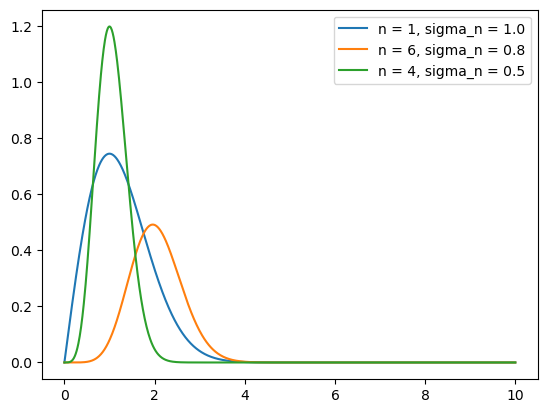

In [82]:
import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt

# Visualize a set of 3 normalized GTOs, with random widths and orders

def gto_norm(r, n, sigma_n):
    I_n = 0.5 * sigma_n**(2 * n + 3) * gamma(n + 1.5)
    N_n = 1/np.sqrt(I_n)
    return N_n * r**n * np.exp(-r**2 / (2 * sigma_n**2))

sigma_n_arr = np.array([1, 0.8, 0.5])
n_arr = np.array([1, 6, 4])

r_grid = np.linspace(0,10,1000)

for i in range(3):
    sigma_n = sigma_n_arr[i]
    n = n_arr[i]
    plt.plot(r_grid, gto_norm(r_grid, n, sigma_n))

plt.legend([f"n = {n_arr[0]}, sigma_n = {sigma_n_arr[0]}",
            f"n = {n_arr[1]}, sigma_n = {sigma_n_arr[1]}",
            f"n = {n_arr[2]}, sigma_n = {sigma_n_arr[2]}"])

plt.show()

Now, we numerically integrate different cases to verify that the GTOs are not yet orthonormal:
Note that the overlap does have an analytic integral, but to prove a point, we just use (pretty bad trapezoidal) numeric integration

In [95]:
import scipy.integrate as integrate

# Note that the integral of a product of the same GTOs (i.e. overlap of same GTOs) have square norm of 1 
# (i.e. the normalization factor is correct)
n1 = n2 = n_arr[0]
sigma_n1 = sigma_n2 = sigma_n_arr[0]

result_identical = np.trapz(gto_norm(r_grid, n1, sigma_n1) * gto_norm(r_grid, n2, sigma_n2) * r_grid**2, r_grid)
print("overlap of identical GTOs", result_identical)

# But are not yet orthoganol: Here, we are looking at the overlap of two GTOs

n1 = n_arr[0]
n2 = n_arr[1]
sigma_n1 = sigma_n_arr[0]
sigma_n2 = sigma_n_arr[1]

result_nonidentical = np.trapz(gto_norm(r_grid, n1, sigma_n1) * gto_norm(r_grid, n2, sigma_n2) * r_grid**2, r_grid)
print("overlap of nonidentical GTOs", result_nonidentical)



overlap of identical GTOs 1.0000000000000002
overlap of nonidentical GTOs 0.742989097543302


###  Now we apply Lodwin's Symmetric Orthonormalization, which can orthonormalize our basis set, using the following steps
1. Find the overlap matrix, whose entries are the overlap integral between two *unnormalized* GTOs: $S_{ij} = \int_0^\infty \phi_i \phi_j r^2 dr$. This matrix is a gram matrix and will hence be hermitian and positive definite
2. Calculate $S^{-1/2}$, which requires diagonalizing the matrix:
    * $S = MDM^T$
    * $S^{-1/2} = M D^{-1/2} M^T$
    * where $D^{-1/2}$ just takes the recipricol square root of each element in the diagonal
3. $S^{-1/2}$ is the orthonormalization matrix. Hence, given a basis set $\underline{\phi} = [\phi_1, ..., \phi_n]$ with corresponding $\sigma_1, ..., \sigma_n$, we can generate orthonormal functions $\underline{\Phi} = \Phi_1, ..., \Phi_n$ with $\underline{\Phi} = S^{-1/2}\underline{\phi}$

In other words, each new orthonormal basis functions are just linear combinations of our original basis funcitions. 

Below, I just pasted a bunch of utility functions below that help us create the overlap and orthonormalization matrices:

In [84]:
def gto(r, n, sigma_n):
    return r**n * np.exp(-r**2 / (2 * sigma_n**2))

def inverse_matrix_sqrt(matrix: np.array):
    """
    Returns the inverse matrix square root.
    The inverse square root of the overlap matrix (or slices of the overlap matrix) yields the
    orthonormalization matrix
    Args:
        matrix: np.array
            Symmetric square matrix to find the inverse square root of

    Returns:
        inverse_sqrt_matrix: S^{-1/2}

    """
    if not np.allclose(matrix, matrix.T):
        raise ValueError("Matrix is not hermitian")
    eva, eve = np.linalg.eigh(matrix)

    if (eva < 0).all():
        raise ValueError("Matrix is not positive semidefinite. Check that a valid gram matrix is passed.")
    return eve @ np.diag(1/np.sqrt(eva)) @ eve.T


def gto_square_norm(n, sigma):
    """
    Compute the square norm of GTOs (inner product of itself over R^3).
    A GTO of order n is \phi_n = r^n * e^{-r^2/(2*\sigma^2)}
    The square norm of the GTO has an analytic solution:
    <\phi_n | \phi_n> = \int_0^\infty dr r^2 |\phi_n|^2 = 1/2 * \sigma^{2n+3} * \Gamma(n+3/2)
    Args:
        n: order of the GTO
        sigma: width of the GTO

    Returns:
        square norm: The square norm of the GTO
    """
    return 0.5 * sigma**(2 * n + 3) * gamma(n + 1.5)


def gto_prefactor(n, sigma):
    """
    Computes the normalization prefactor of a GTO.
    This prefactor is simply 1/sqrt(square_norm_area).
    Scaling a GTO by this prefactor will ensure that the GTO has square norm equal to 1.
    Args:
        n: order of GTO
        sigma: width of GTO

    Returns:
        N: normalization constant

    """
    return np.sqrt(1 / gto_square_norm(n, sigma))


def gto_overlap(n, m, sigma_n, sigma_m):
    """
    Compute overlap of two GTOs
    Note that the overlap of two GTOs can be modeled as the square norm of one GTO, with an effective
    n and sigma. All we need to do is to calculate those effective parameters, then compute the normalization.
    <\phi_n, \phi_m> = \int_0^\infty dr r^2 r^n * e^{-r^2/(2*\sigma_n^2) * r^m * e^{-r^2/(2*\sigma_m^2)
    = \int_0^\infty dr r^2 |r^{(n+m)/2} * e^{-r^2/4 * (1/\sigma_n^2 + 1/\sigma_m^2)}|^2
    = \int_0^\infty dr r^2 r^n_{eff} * e^{-r^2/(2*\sigma_{eff}^2)
    prefactor.
    ---Arguments---
    n: order of the first GTO
    m: order of the second GTO
    sigma_n: sigma parameter of the first GTO
    sigma_m: sigma parameter of the second GTO

    ---Returns---
    S: overlap of the two GTOs
    """
    n_eff = (n + m) / 2
    sigma_eff = np.sqrt(2 * sigma_n**2 * sigma_m**2 / (sigma_n**2 + sigma_m**2))
    return gto_square_norm(n_eff, sigma_eff)

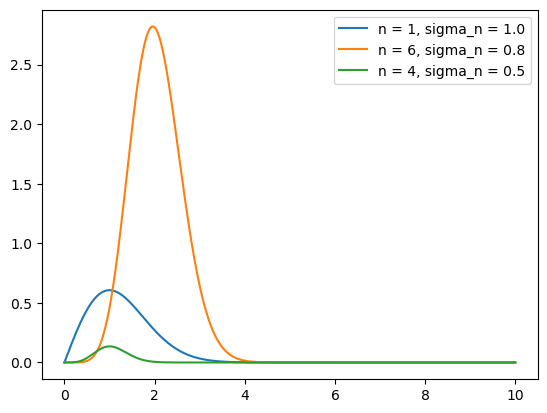

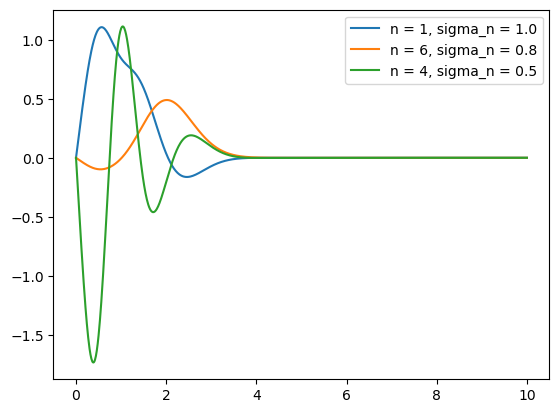

In [101]:
overlap_matrix = gto_overlap(n_arr[:, np.newaxis],
                             n_arr[np.newaxis, :],
                             sigma_n_arr[:, np.newaxis],
                             sigma_n_arr[np.newaxis, :])
orthonormalization_matrix = inverse_matrix_sqrt(overlap_matrix)

# The original nonorthonormalized basis set is (these aren't normalized either!):
original_gto = np.array([gto(r_grid, n_arr[0], sigma_n_arr[0]),
                         gto(r_grid, n_arr[1], sigma_n_arr[1]),
                         gto(r_grid, n_arr[2], sigma_n_arr[2])])
plt.plot(r_grid, original_gto.T)
plt.legend([f"n = {n_arr[0]}, sigma_n = {sigma_n_arr[0]}",
            f"n = {n_arr[1]}, sigma_n = {sigma_n_arr[1]}",
            f"n = {n_arr[2]}, sigma_n = {sigma_n_arr[2]}"])

plt.show()

# Now, plot orthonormalized basis
orthonormal_gto = orthonormalization_matrix @ original_gto

plt.plot(r_grid, orthonormal_gto.T)
plt.legend([f"n = {n_arr[0]}, sigma_n = {sigma_n_arr[0]}",
            f"n = {n_arr[1]}, sigma_n = {sigma_n_arr[1]}",
            f"n = {n_arr[2]}, sigma_n = {sigma_n_arr[2]}"])
plt.show()

These new functions are orthonormal:

In [104]:
import scipy.integrate as integrate

# Two identical functions have a overlap of 1:

result_identical = np.trapz(orthonormal_gto[0, :] * orthonormal_gto[0, :] * r_grid**2, r_grid)
print("overlap of identical orthonormalized GTOs", result_identical)

# Nonidentical functions have an overlap of 0:

result_nonidentical = np.trapz(orthonormal_gto[0, :] * orthonormal_gto[1, :] * r_grid**2, r_grid)
print("overlap of nonidentical orthonormalized GTOs", result_nonidentical)


overlap of identical orthonormalized GTOs 0.9999999999999972
overlap of nonidentical orthonormalized GTOs 5.257868827118135e-16
